In [3]:
import numpy as np
import pandas as pd

# データの取り込み

# import data
data = pd.read_csv(r"./gender-classifier-DFE-791531.csv",encoding='latin1')

# concat gender and description
data = pd.concat([data.gender,data.description,data.text],axis=1)

#drop nan values inplace
data.dropna(inplace=True,axis=0)
data = data.reset_index(drop=True)

In [4]:
import re

def remove_urls(text):
    
    urls = [g[0] for g in re.findall(r'((https?|ftp)(:\/\/[-_\.!~*\'()a-zA-Z0-9;\/?:\@&=\+\$,%#]+))', text)]
    
    for url in sorted(urls,key=lambda x:-len(x)):
    
        text = text.replace(url,'')
        
    return text

In [5]:
data.gender.loc[data.gender == 'male']   = 0
data.gender.loc[data.gender == 'female'] = 1
data.gender.loc[~(data.gender == 0) & ~(data.gender == 1)] = np.nan

data.description = data.description.map(remove_urls)
data.text = data.text.map(remove_urls)

data.dropna(inplace=True,axis=0)
data = data.reset_index(drop=True)
data.gender = data.gender.astype(int)

In [25]:
# preprocessing
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
from collections import defaultdict,Counter

docs = []

w2i  = defaultdict(lambda : len(w2i))

mystopwords = stopwords.words('english') + ["i'm","rt"]

tokenizer = RegexpTokenizer("(?u)(?=[a-zA-Z])\\b[\w']{2,}\\b")

'''
for text in data.description:

    tokens = tokenizer.tokenize(text)
    docs.append([w2i[w.lower()] for w in tokens])
'''    
for text in data.text:

    tokens = tokenizer.tokenize(text)
    docs.append([w2i[w.lower()] for w in tokens])

In [26]:
dim = len(w2i)
max_len = 10

In [27]:
from keras import preprocessing

x = preprocessing.sequence.pad_sequences(docs, maxlen=max_len)

In [28]:
import numpy as np

y = np.asarray(data.gender.values).astype('float32')

In [29]:
# train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

In [30]:
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
from keras import losses
from keras import regularizers
from keras.layers import Flatten, Dense, Embedding, LSTM, GRU, Bidirectional

model = models.Sequential()
model.add(Embedding(dim, 128, input_length=max_len))
#model.add(LSTM(32))
#model.add(GRU(32,dropout=0.2,recurrent_dropout=0.2))
model.add(Bidirectional(LSTM(128)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 10, 128)           2928256   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 1028      
_________________________________________________________________
dropout_5 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 5         
Total params: 3,192,457
Trainable params: 3,192,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=30,
                    batch_size=100,
                    validation_split=0.2)

Train on 8059 samples, validate on 2015 samples
Epoch 1/30
8059/8059 [==============================] - 5s 601us/step - loss: 0.6914 - acc: 0.5131 - val_loss: 0.6857 - val_acc: 0.5712
Epoch 2/30
8059/8059 [==============================] - 4s 526us/step - loss: 0.6702 - acc: 0.5807 - val_loss: 0.6732 - val_acc: 0.5806
Epoch 3/30
8059/8059 [==============================] - 4s 532us/step - loss: 0.6225 - acc: 0.6585 - val_loss: 0.6724 - val_acc: 0.5846
Epoch 4/30
8059/8059 [==============================] - 4s 522us/step - loss: 0.5658 - acc: 0.7134 - val_loss: 0.7012 - val_acc: 0.5757
Epoch 5/30
8059/8059 [==============================] - 4s 486us/step - loss: 0.5103 - acc: 0.7466 - val_loss: 0.7418 - val_acc: 0.5772
Epoch 6/30
8059/8059 [==============================] - 4s 516us/step - loss: 0.4623 - acc: 0.7711 - val_loss: 0.7402 - val_acc: 0.5697
Epoch 7/30
8059/8059 [==============================] - 4s 501us/step - loss: 0.4471 - acc: 0.7841 - val_loss: 0.7769 - val_acc: 0.5806


In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

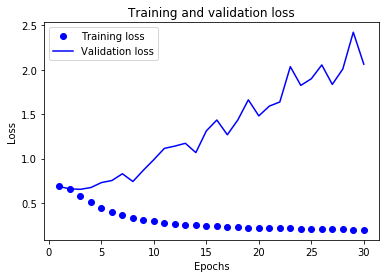

In [21]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

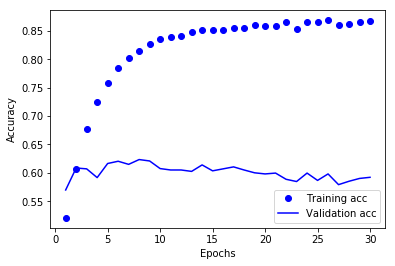

In [22]:
plt.clf()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
results = model.evaluate(x_test, y_test)

1120/1120 [==============================] - 0s 382us/step


In [24]:
results

[1.835210861478533, 0.61785714285714288]